In [12]:
# Importando bibliotecas

import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Importando arquitetura do modelo
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Instanciando os pesos pré-treinados
weights = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [24]:
pre_trained_model = InceptionV3(
	input_shape=(150,150,3),
	include_top = False, # Como vamos mudar o tamanho das imagens devemos deixar como False.
	weights=None # Não vamos pegar pesos do banco de dados, vamos pegar pelo arquivo
)

# Freezando os layers da rede pré-treinada
for layer in pre_trained_model.layers:
  layer.trainable=False

pre_trained_model.load_weights(weights) # Carregando os pesos

In [25]:
# Observar modelo
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [26]:
# Vamos pegar até o layer antes do Flatten (mixed7)
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


In [29]:
# Definindo callback
class myCallBack(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy')>0.999):
		  print('\nReached 99.9% accuracy so cancelling training!')
		  self.model.stop_training=True

callbacks = myCallBack()

In [28]:
# Conectando o modelo nos layers que criamos
# Utiliza outro tipo de nomenclatura conforme podemos ver abaixo:
x = tf.keras.layers.Flatten()(last_output)
# Adicionando layer denso com 1024 nós
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
# Adicionando layer de DROPOUT para evitar overfitting
x = tf.keras.layers.Dropout(.2)(x)
# Layer final de classificação
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x) # Conectando

model.compile(
	optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']
)

In [19]:
# Baixando dados
!pip install wget # para instalar no google colab
import wget
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip"
filename = wget.download(url)

url_valid = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip"
filename_valid = wget.download(url_valid)
 


In [21]:
# Descompactando e criando pasta de treino e teste

local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [22]:
# Definindo os diretórios e arquivos
train_dir = '/tmp/training/'
validation_dir = '/tmp/validation'

# Pegando path de cada pasta
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Listando arquivos
train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

# Printando quantidade de arquivos em cada pasta
print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [23]:
# Criando DataGenerator com aumento de dados
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Não aumentarei o Validation Set

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# criando gerador
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)



Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [30]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/50
17/17 [==============================] - 14s 817ms/step - loss: 2.2152 - accuracy: 0.8987 - val_loss: 0.2642 - val_accuracy: 0.9688
Epoch 2/50
17/17 [==============================] - 14s 824ms/step - loss: 0.1693 - accuracy: 0.9825 - val_loss: 0.0660 - val_accuracy: 0.9844
Epoch 3/50
17/17 [==============================] - 13s 776ms/step - loss: 0.1558 - accuracy: 0.9766 - val_loss: 0.0798 - val_accuracy: 0.9883
Epoch 4/50
17/17 [==============================] - 13s 780ms/step - loss: 0.8978 - accuracy: 0.9552 - val_loss: 0.1574 - val_accuracy: 0.9844
Epoch 5/50
17/17 [==============================] - 13s 774ms/step - loss: 0.1224 - accuracy: 0.9893 - val_loss: 0.0233 - val_accuracy: 0.9961
Epoch 6/50
17/17 [==============================] - 13s 773ms/step - loss: 0.1081 - accuracy: 0.9844 - val_loss: 3.0075e-09 - val_accuracy: 1.0000
Epoch 7/50
17/17 [==============================] - 13s 778ms/step - loss: 0.1016 - accuracy: 0.9912 - val_loss: 0.3275 - val_accuracy: 0.

Text(0.5, 1.0, 'Loss x Epochs')

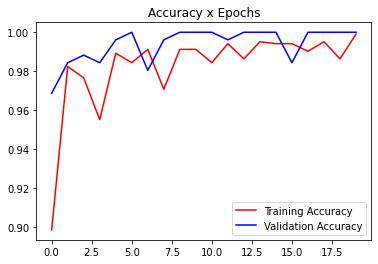

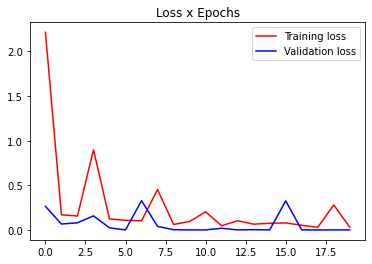

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy x Epochs')

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.title('Loss x Epochs')

